In [134]:
# Import Required Libraries
library(dplyr)
library(tsibble)
library(fable)
library(ggplot2)
library(tidyr)
library(purrr)
library(feasts)

# Source Helper Functions
source("baseline_helpers.R")
source("../Data_Inspection/data_cleaning_helpers.R")


In [244]:
# Clean validation data
validation <- get_validation_data()

## Load and Clean Train Data

In [136]:
# Load dates
dates <- read.csv("../calendar_afcs2025.csv") |> mutate(date = as.Date(date, format = "%m/%d/%Y"))
dates <- dates |> rename(day = date)

# added this later, might break everything, gotta check it
dates <- dates |> as_tsibble(index = day, key = wm_yr_wk)

# adding dummy variables for each weekday
dates <- dates |>
  mutate(
    wd_monday    = as.integer(weekday == "Monday"),
    wd_tuesday   = as.integer(weekday == "Tuesday"),
    wd_wednesday = as.integer(weekday == "Wednesday"),
    wd_thursday  = as.integer(weekday == "Thursday"),
    wd_friday    = as.integer(weekday == "Friday"),
    wd_saturday  = as.integer(weekday == "Saturday")
  )

dates <- dates |>
  mutate(
    m_january   = as.integer(month == 1),
    m_february  = as.integer(month == 2),
    m_march     = as.integer(month == 3),
    m_april     = as.integer(month == 4),
    m_may       = as.integer(month == 5),
    m_june      = as.integer(month == 6),
    m_july      = as.integer(month == 7),
    m_august    = as.integer(month == 8),
    m_september = as.integer(month == 9),
    m_october   = as.integer(month == 10),
    m_november  = as.integer(month == 11)
  )

# way too many unique event names so many we just focus on this,
# it's implemented with an or because event1 and event2 are always different type,
# and they can be in either order

# adding dummy variables for each event category
dates <- dates |>
  mutate(
    et_sporting  = as.integer((event_type_1 == "Sporting" | event_type_2 == "Sporting") %in% TRUE),
    et_cultural  = as.integer((event_type_1 == "Cultural" | event_type_2 == "Cultural") %in% TRUE),
    et_national  = as.integer((event_type_1 == "National" | event_type_2 == "National") %in% TRUE),
    et_religious = as.integer((event_type_1 == "Religious" | event_type_2 == "Religious") %in% TRUE)
  )


# event name

train <- get_train_data()


In [137]:
train

# A tsibble: 1,246,617 x 36 [1D]
# Key:       product [823]
# Groups:    product [823]
   day        product     sales wm_yr_wk weekday   wday month  year event_name_1
   <date>     <chr>       <dbl>    <int> <chr>    <int> <int> <int> <chr>       
 1 2011-01-29 FOODS_3_001 0        11101 Saturday     1     1  2011 NA          
 2 2011-01-30 FOODS_3_001 1.10     11101 Sunday       2     1  2011 NA          
 3 2011-01-31 FOODS_3_001 0.693    11101 Monday       3     1  2011 NA          
 4 2011-02-01 FOODS_3_001 1.39     11101 Tuesday      4     2  2011 NA          
 5 2011-02-02 FOODS_3_001 0        11101 Wednesd…     5     2  2011 NA          
 6 2011-02-03 FOODS_3_001 0        11101 Thursday     6     2  2011 NA          
 7 2011-02-04 FOODS_3_001 0.693    11101 Friday       7     2  2011 NA          
 8 2011-02-05 FOODS_3_001 0        11102 Saturday     1     2  2011 NA          
 9 2011-02-06 FOODS_3_001 1.10     11102 Sunday       2     2  2011 SuperBowl   
10 2011-02-07 FOODS_3_

# take subset of train and validation

In [138]:
# start <- 1
# end <- 50
# products <- sprintf("FOODS_3_%03d", start:end)

# train <- train |> filter(product %in% products)
# validation <- validation |> filter(product %in% products)


## Baseline Prediction & Evaluation

Mean baseline

In [139]:
means <- train |>
  as_tibble() |>
  group_by(product) |>
  summarise(mean_sales = mean(sales))

mean_forecasts <- new_data(ungroup(train), n = 28) |>
  left_join(means, by = "product") |>
  rename(sales = mean_sales) |>
  as_tibble()

aligned_data <- align_predictions(mean_forecasts, validation)
accuracy_mean <- calculate_metrics(aligned_data)

Naive Baseline

In [140]:
path <- "models/baseline/naive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  fit <- readRDS(path)
} else {
  fit <- train |>
    model(
      NAIVE(sales)
    )
  saveRDS(fit, path)
}


naive_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(naive_forecasts, validation)
accuracy_naive <- calculate_metrics(aligned_data)

Seasonal Naive Baseline

In [141]:
path <- "models/baseline/snaive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  fit <- readRDS(path)
} else {
  fit <- train |>
    model(
      SNAIVE(sales)
    )
  saveRDS(fit, path)
}

snaive_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(snaive_forecasts, validation)
accuracy_snaive <- calculate_metrics(aligned_data)


ARIMA Baseline

In [142]:
path <- "models/baseline/arima.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  fit <- readRDS(path)
} else {
  fit <- train |>
    model(
      ARIMA(sales)
    )
  saveRDS(fit, path)
}

arima_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(arima_forecasts, validation)
accuracy_arima <- calculate_metrics(aligned_data)

In [143]:
View(fit)

In [144]:
warnings()

Warning messages:
1: In sqrt(diag(best$var.coef)) : NaNs produced
2: In sqrt(diag(best$var.coef)) : NaNs produced
3: In sqrt(diag(best$var.coef)) : NaNs produced
4: In sqrt(diag(best$var.coef)) : NaNs produced
5: In sqrt(diag(best$var.coef)) : NaNs produced
6: In sqrt(diag(best$var.coef)) : NaNs produced
7: In sqrt(diag(best$var.coef)) : NaNs produced
8: In sqrt(diag(best$var.coef)) : NaNs produced
9: In sqrt(diag(best$var.coef)) : NaNs produced

ETS Baseline

In [145]:
path <- "models/baseline/ets.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  fit <- readRDS(path)
} else {
  fit <- train |>
    model(
      ETS(sales)
    )
  saveRDS(fit, path)
}

ets_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(ets_forecasts, validation)
accuracy_ets <- calculate_metrics(aligned_data)

In [146]:
View(validation)

Checking performance of ensemble of baseline models

In [147]:
ensemble_forecasts <- naive_forecasts |>
    inner_join(snaive_forecasts, by = c("product", "day"), suffix = c("_naive", "_snaive")) |>
    inner_join(arima_forecasts, by = c("product", "day")) |>
    inner_join(ets_forecasts, by = c("product", "day"), suffix = c("_arima", "_ets")) |>
    mutate(
        sales = (sales_naive + sales_snaive + sales_arima + sales_ets) / 4
    ) |>
    select(product, day, sales)
aligned_data <- align_predictions(ensemble_forecasts, validation)
accuracy_ensemble <- calculate_metrics(aligned_data)
accuracy_ensemble


In [148]:
View(arima_forecasts)

Evaluate baselines

# A tibble: 5 × 3
  model   RMSE   MAE
  <chr>  <dbl> <dbl>
1 mean    5.63  2.07
2 naive   4.11  1.82
3 snaive  3.68  1.70
4 arima   3.18  1.41
5 ets     3.10  1.43


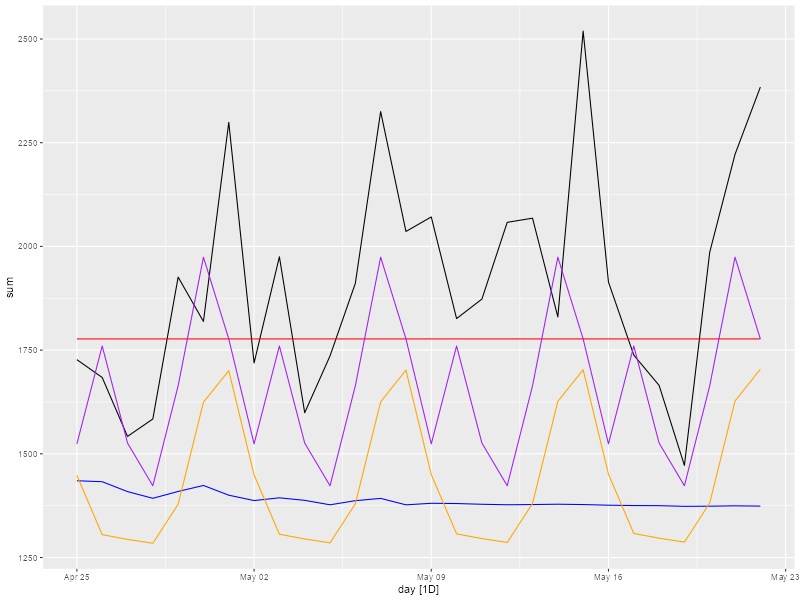

In [149]:
sums_mean <- mean_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_naive <- naive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_snaive <- snaive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_arima <- arima_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_ets <- ets_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))


sums_val <- validation |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

# accuracy table
baseline_accuracy <- bind_rows(
  mean = accuracy_mean,
  naive = accuracy_naive,
  snaive = accuracy_snaive,
  arima = accuracy_arima,
  ets = accuracy_ets,
  .id = "model"
)

print(baseline_accuracy)

# plotting against validation to see what is being captured
(sums_val |> autoplot(.vars = sum)) +
  autolayer(sums_naive, sum, color = "red") +
  autolayer(sums_snaive, sum, color = "purple") +
  autolayer(sums_arima, sum, color = "blue") +
  autolayer(sums_ets, sum, color = "orange")


# Actual interesting model (basedline)

Dynamic regression on Sell Price as predictor

In [150]:
path <- "models/arima_model.rds"

if (file.exists(path)) {
  arima_fit <- readRDS(path)
} else {
  arima_fit <- train |>
    model(
      ARIMA(sales ~ sell_price)
    )

  saveRDS(arima_fit, path)
}


Naive Price

In [151]:
path <- "models/prices/naive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  price_fit_naive <- readRDS(path)
} else {
  # fitting a naive
  price_fit_naive <- train |>
    model(NAIVE(sell_price))

  saveRDS(price_fit_naive, path)
}

# fitting a naive
price_fit_naive <- train |>
  model(NAIVE(sell_price))

sell_price_future_naive <- price_fit_naive |>
  forecast(h = "28 days") |>
  as_tsibble() |>
  select(product, day, .mean) |>
  rename(sell_price = .mean)

naive_forecasts <- forecast(arima_fit, new_data = sell_price_future_naive) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  select(day, product, sales)


aligned_data <- align_predictions(naive_forecasts, validation)
accuracy_naive <- calculate_metrics(aligned_data)

Snaive Price

In [152]:
path <- "models/prices/snaive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  price_fit_snaive <- readRDS(path)
} else {
  # fitting a seasonal naive
  price_fit_snaive <- train |>
    model(SNAIVE(sell_price))

  saveRDS(price_fit_snaive, path)
}

# forecast price
sell_price_future_snaive <- price_fit_snaive |>
  forecast(h = "28 days") |>
  as_tsibble() |>
  select(product, day, .mean) |>
  rename(sell_price = .mean)

# forecast sales based on this price as future data
snaive_forecasts <- forecast(arima_fit, new_data = sell_price_future_snaive) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  select(day, product, sales)


aligned_data <- align_predictions(snaive_forecasts, validation)
accuracy_snaive <- calculate_metrics(aligned_data)


ARIMA price

In [153]:
path <- "models/prices/arima.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  price_fit_arima <- readRDS(path)
} else {
  # fitting an arima, probably need to decide what kind of d is nice
  price_fit_arima <- train |>
    model(ARIMA(sell_price))

  saveRDS(price_fit_arima, path)
}

sell_price_future_arima <- price_fit_arima |>
  forecast(h = "28 days") |>
  as_tsibble() |>
  select(product, day, .mean) |>
  rename(sell_price = .mean)

arima_forecasts <- forecast(arima_fit, new_data = sell_price_future_arima) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  select(day, product, sales)


aligned_data <- align_predictions(arima_forecasts, validation)
accuracy_arima <- calculate_metrics(aligned_data)


ETS Price

In [154]:
path <- "models/prices/ets.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  price_fit_ets <- readRDS(path)
} else {
  # fitting an ets
  price_fit_ets <- train |>
    model(ETS(sell_price))

  saveRDS(price_fit_ets, path)
}

sell_price_future_ets <- price_fit_ets |>
  forecast(h = "28 days") |>
  as_tsibble() |>
  select(product, day, .mean) |>
  rename(sell_price = .mean)

ets_forecasts <- forecast(arima_fit, new_data = sell_price_future_ets) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  select(day, product, sales)


aligned_data <- align_predictions(ets_forecasts, validation)
accuracy_ets <- calculate_metrics(aligned_data)


Evaluate them

# A tibble: 4 × 3
  model   RMSE   MAE
  <chr>  <dbl> <dbl>
1 naive     NA    NA
2 snaive    NA    NA
3 arima     NA    NA
4 ets       NA    NA


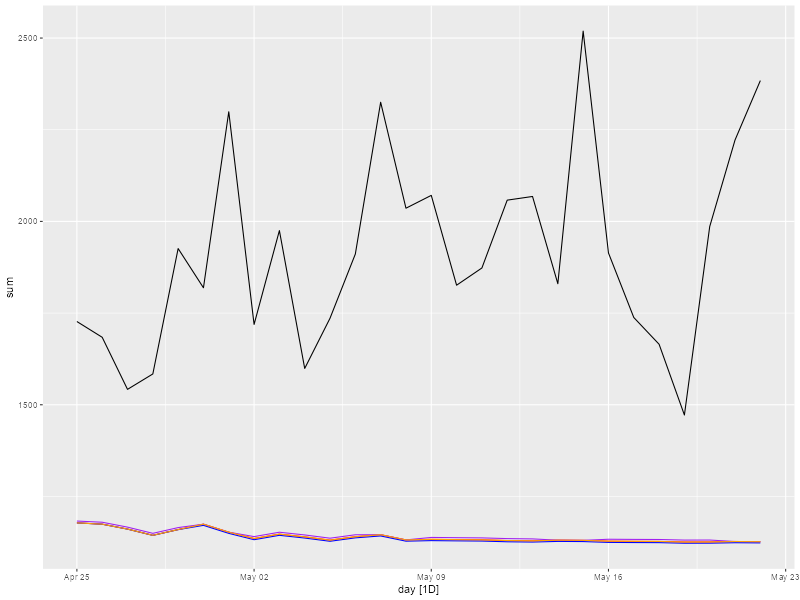

In [155]:
sums_naive <- naive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_snaive <- snaive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_arima <- arima_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_ets <- ets_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))


sums_val <- validation |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

# accuracy table
dynamic_price_accuracy <- bind_rows(
  naive = accuracy_naive,
  snaive = accuracy_snaive,
  arima = accuracy_arima,
  ets = accuracy_ets,
  .id = "model"
)

print(dynamic_price_accuracy)

# plotting against validation to see what is being captured
(sums_val |> autoplot(.vars = sum)) +
  autolayer(sums_naive, sum, color = "red") +
  autolayer(sums_snaive, sum, color = "purple") +
  autolayer(sums_arima, sum, color = "blue") +
  autolayer(sums_ets, sum, color = "orange")


Calander predictors incorporated

In [156]:
# extending it by adding calander data
sell_price_future_naive_cal <- inner_join(
    sell_price_future_naive,
    dates,
    by = c("day")
)

sell_price_future_snaive_cal <- inner_join(
    sell_price_future_snaive,
    dates,
    by = c("day")
)

sell_price_future_arima_cal <- inner_join(
    sell_price_future_arima,
    dates,
    by = c("day")
)

sell_price_future_ets_cal <- inner_join(
    sell_price_future_ets,
    dates,
    by = c("day")
)


In [157]:
sell_price_future_ets_cal

# A tsibble: 23,044 x 34 [1D]
# Key:       product [823]
   product day        sell_price wm_yr_wk weekday  wday month  year event_name_1
   <chr>   <date>          <dbl>    <int> <chr>   <int> <int> <int> <chr>       
 1 FOODS_… 2016-04-25        2.5    11613 Monday      3     4  2016 NA          
 2 FOODS_… 2016-04-26        2.5    11613 Tuesday     4     4  2016 NA          
 3 FOODS_… 2016-04-27        2.5    11613 Wednes…     5     4  2016 NA          
 4 FOODS_… 2016-04-28        2.5    11613 Thursd…     6     4  2016 NA          
 5 FOODS_… 2016-04-29        2.5    11613 Friday      7     4  2016 NA          
 6 FOODS_… 2016-04-30        2.5    11614 Saturd…     1     4  2016 Pesach End  
 7 FOODS_… 2016-05-01        2.5    11614 Sunday      2     5  2016 OrthodoxEas…
 8 FOODS_… 2016-05-02        2.5    11614 Monday      3     5  2016 NA          
 9 FOODS_… 2016-05-03        2.5    11614 Tuesday     4     5  2016 NA          
10 FOODS_… 2016-05-04        2.5    11614 Wednes…   

arima model with events and date types incorporated

In [ ]:
path <- "models/arima_models/arima_model_cal_all.rds"

if (file.exists(path)) {
  arima_fit_cal_first <- readRDS(path)
} else {
  arima_fit_cal_first <- train |>
    model(
      ARIMA(
        sales ~ sell_price +

          # weekdays (Sunday reference)
          wd_monday + wd_tuesday + wd_wednesday +
          wd_thursday + wd_friday + wd_saturday +

          # months (December reference)
          m_january + m_february + m_march + m_april +
          m_may + m_june + m_july + m_august +
          m_september + m_october + m_november +

          # events
          et_sporting + et_cultural +
          et_national + et_religious +

          snap_TX
      )
    )

  saveRDS(arima_fit_cal_first, path)	
}

In [ ]:
path <- "models/arima_models/arima_model_cal_snap.rds"

if (file.exists(path)) {
  arima_fit_cal_first <- readRDS(path)
} else {
  arima_fit_cal_first <- train |>
    model(
      ARIMA(
        sales ~ sell_price +
          snap_TX
      )
    )

  saveRDS(arima_fit_cal_first, path)
}

In [ ]:
path <- "models/arima_models/arima_model_cal_snap_events.rds"

if (file.exists(path)) {
  arima_fit_cal_first <- readRDS(path)
} else {
  arima_fit_cal_first <- train |>
    model(
      ARIMA(
        sales ~ sell_price +

          # events
          et_sporting + et_cultural +
          et_national + et_religious +

          snap_TX
      )
    )

  saveRDS(arima_fit_cal_first, path)
}

There were 50 or more warnings (use warnings() to see the first 50)


In [ ]:
path <- "models/arima_models/arima_model_cal_events.rds"

if (file.exists(path)) {
  arima_fit_cal_first <- readRDS(path)
} else {
  arima_fit_cal_first <- train |>
    model(
      ARIMA(
        sales ~ sell_price +


          # events
          et_sporting + et_cultural +
          et_national + et_religious
      )
    )

  saveRDS(arima_fit_cal_first, path)
}

rename model column, sorry this could've been coded better...

In [ ]:
arima_fit_cal_first <- arima_fit_cal |> rename(model = `ARIMA(sales ~ sell_price + wd_monday + wd_tuesday + wd_wednesday + \n    wd_thursday + wd_friday + wd_saturday + m_january + m_february + \n    m_march + m_april + m_may + m_june + m_july + m_august + \n    m_september + m_october + m_november + et_sporting + et_cultural + \n    et_national + et_religious + snap_TX)`)

get products with null models

In [ ]:
null_products <- arima_fit_cal_first |> 
      as_tibble() |>
      filter(map_lgl(model, is_null_model)) |> 
      select(product)



refit models for those products

In [ ]:
refit_nulls <- train |>
  semi_join(null_products, by = "product") |>
  model(
    model = ARIMA(sales ~  pdq(0:1, 0:1, 0:1) + 
          snap_TX)
  )


check if any of these are null

In [ ]:
refit_nulls |> as_tibble() |>
      filter(map_lgl(model, is_null_model)) |> 
      select(product)

get initial models and combine it

In [ ]:
good_models <- arima_fit_cal_first |>
  filter(!map_lgl(model, is_null_model))
good_models

In [ ]:
arima_fit_fixed <- bind_rows(
  good_models,
  refit_nulls
)
arima_fit_cal <- arima_fit_fixed

perform the forecasts

In [216]:
# naive
naive_forecasts <- forecast(arima_fit_cal, new_data = sell_price_future_naive_cal) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(day, product, sales)


aligned_data <- align_predictions(naive_forecasts, validation)
accuracy_naive <- calculate_metrics(aligned_data)

# snaive
snaive_forecasts <- forecast(arima_fit_cal, new_data = sell_price_future_snaive_cal) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(day, product, sales)


aligned_data <- align_predictions(snaive_forecasts, validation)
accuracy_snaive <- calculate_metrics(aligned_data)

# arima
arima_forecasts <- forecast(arima_fit_cal, new_data = sell_price_future_arima_cal) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(day, product, sales)


aligned_data <- align_predictions(arima_forecasts, validation)
accuracy_arima <- calculate_metrics(aligned_data)

# ets
ets_forecasts <- forecast(arima_fit_cal, new_data = sell_price_future_ets_cal) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(day, product, sales)


aligned_data <- align_predictions(ets_forecasts, validation)
accuracy_ets <- calculate_metrics(aligned_data)


evaluate them

# A tibble: 4 × 3
  model   RMSE   MAE
  <chr>  <dbl> <dbl>
1 naive   3.29  1.49
2 snaive  3.29  1.49
3 arima   3.30  1.49
4 ets     3.29  1.49


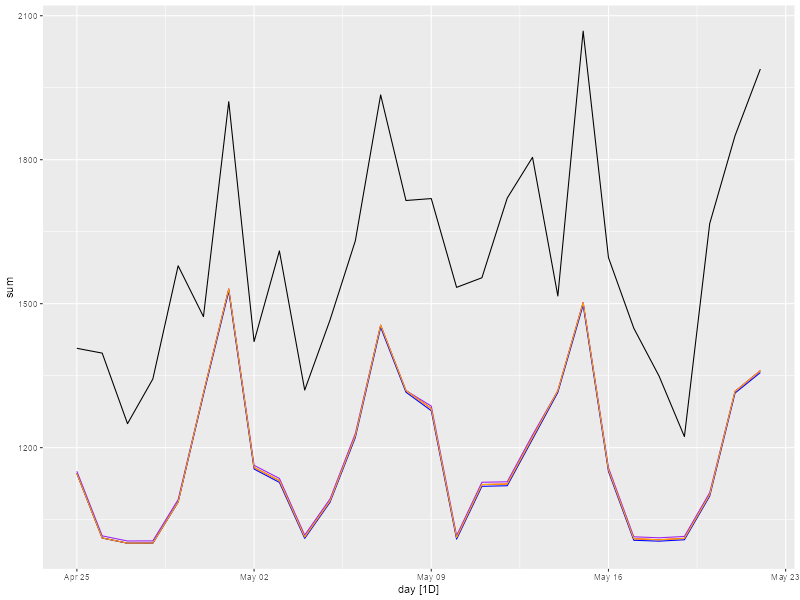

In [218]:
sums_naive <- naive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_snaive <- snaive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_arima <- arima_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_ets <- ets_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))


sums_val <- validation_filtered |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

# accuracy table
dynamic_price_accuracy <- bind_rows(
  naive = accuracy_naive,
  snaive = accuracy_snaive,
  arima = accuracy_arima,
  ets = accuracy_ets,
  .id = "model"
)

print(dynamic_price_accuracy)

# plotting against validation to see what is being captured
(sums_val |> autoplot(.vars = sum)) +
  autolayer(sums_naive, sum, color = "red") +
  autolayer(sums_snaive, sum, color = "purple") +
  autolayer(sums_arima, sum, color = "blue") +
  autolayer(sums_ets, sum, color = "orange")


In [245]:
arima_fit_cal <- arima_fit_fixed
# naive
naive_forecasts <- forecast(arima_fit_cal, new_data = sell_price_future_naive_cal) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(day, product, sales)


aligned_data <- align_predictions(naive_forecasts, validation)
accuracy_naive <- calculate_metrics(aligned_data)

# snaive
snaive_forecasts <- forecast(arima_fit_cal, new_data = sell_price_future_snaive_cal) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(day, product, sales)


aligned_data <- align_predictions(snaive_forecasts, validation)
accuracy_snaive <- calculate_metrics(aligned_data)

# arima
arima_forecasts <- forecast(arima_fit_cal, new_data = sell_price_future_arima_cal) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(day, product, sales)


aligned_data <- align_predictions(arima_forecasts, validation)
accuracy_arima <- calculate_metrics(aligned_data)

# ets
ets_forecasts <- forecast(arima_fit_cal, new_data = sell_price_future_ets_cal) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(day, product, sales)


aligned_data <- align_predictions(ets_forecasts, validation)
accuracy_ets <- calculate_metrics(aligned_data)


# A tibble: 4 × 3
  model   RMSE   MAE
  <chr>  <dbl> <dbl>
1 naive   3.17  1.43
2 snaive  3.16  1.43
3 arima   3.17  1.43
4 ets     3.17  1.43


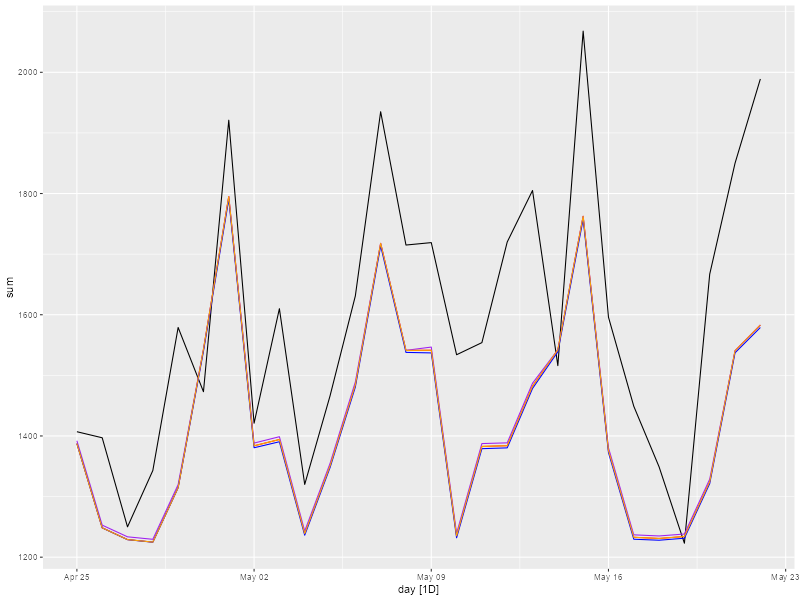

In [246]:
sums_naive <- naive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_snaive <- snaive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_arima <- arima_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_ets <- ets_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))


sums_val <- validation_filtered |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

# accuracy table
dynamic_price_accuracy <- bind_rows(
  naive = accuracy_naive,
  snaive = accuracy_snaive,
  arima = accuracy_arima,
  ets = accuracy_ets,
  .id = "model"
)

print(dynamic_price_accuracy)

# plotting against validation to see what is being captured
(sums_val |> autoplot(.vars = sum)) +
  autolayer(sums_naive, sum, color = "red") +
  autolayer(sums_snaive, sum, color = "purple") +
  autolayer(sums_arima, sum, color = "blue") +
  autolayer(sums_ets, sum, color = "orange")


In [ ]:
# validation_filtered <- validation |>
#   anti_join(null_products, by = "product")

# arima_fit_cal <- arima_fit_cal |>
#   anti_join(null_products, by = "product")

In [235]:
arima_fit_cal

# A mable: 823 x 2
# Key:     product [823]
   product                                     model
   <chr>                                     <model>
 1 FOODS_3_001 <LM w/ ARIMA(2,1,1)(1,0,1)[7] errors>
 2 FOODS_3_002 <LM w/ ARIMA(3,1,2)(1,0,0)[7] errors>
 3 FOODS_3_003 <LM w/ ARIMA(0,1,1)(1,0,1)[7] errors>
 4 FOODS_3_004 <LM w/ ARIMA(2,0,1)(0,0,1)[7] errors>
 5 FOODS_3_005 <LM w/ ARIMA(2,0,2)(1,0,1)[7] errors>
 6 FOODS_3_006                          <NULL model>
 7 FOODS_3_007 <LM w/ ARIMA(2,1,3)(1,0,0)[7] errors>
 8 FOODS_3_008 <LM w/ ARIMA(1,1,2)(2,0,0)[7] errors>
 9 FOODS_3_009                          <NULL model>
10 FOODS_3_010 <LM w/ ARIMA(0,0,0)(1,0,0)[7] errors>
# ℹ 813 more rows
# ℹ Use `print(n = ...)` to see more rows

In [174]:
sell_price_future_ets_cal

# A tsibble: 23,044 x 34 [1D]
# Key:       product [823]
   product day        sell_price wm_yr_wk weekday  wday month  year event_name_1
   <chr>   <date>          <dbl>    <int> <chr>   <int> <int> <int> <chr>       
 1 FOODS_… 2016-04-25        2.5    11613 Monday      3     4  2016 NA          
 2 FOODS_… 2016-04-26        2.5    11613 Tuesday     4     4  2016 NA          
 3 FOODS_… 2016-04-27        2.5    11613 Wednes…     5     4  2016 NA          
 4 FOODS_… 2016-04-28        2.5    11613 Thursd…     6     4  2016 NA          
 5 FOODS_… 2016-04-29        2.5    11613 Friday      7     4  2016 NA          
 6 FOODS_… 2016-04-30        2.5    11614 Saturd…     1     4  2016 Pesach End  
 7 FOODS_… 2016-05-01        2.5    11614 Sunday      2     5  2016 OrthodoxEas…
 8 FOODS_… 2016-05-02        2.5    11614 Monday      3     5  2016 NA          
 9 FOODS_… 2016-05-03        2.5    11614 Tuesday     4     5  2016 NA          
10 FOODS_… 2016-05-04        2.5    11614 Wednes…   

In [173]:
arima_fit_cal

# A mable: 823 x 2
# Key:     product [823]
   product     ARIMA(sales ~ sell_price + wd_monday + wd_tuesday + wd_wednesda…¹
   <chr>                                                                 <model>
 1 FOODS_3_001                             <LM w/ ARIMA(2,1,1)(1,0,1)[7] errors>
 2 FOODS_3_002                             <LM w/ ARIMA(3,1,2)(1,0,0)[7] errors>
 3 FOODS_3_003                             <LM w/ ARIMA(0,1,1)(1,0,1)[7] errors>
 4 FOODS_3_004                             <LM w/ ARIMA(2,0,1)(0,0,1)[7] errors>
 5 FOODS_3_005                             <LM w/ ARIMA(2,0,2)(1,0,1)[7] errors>
 6 FOODS_3_006                                                      <NULL model>
 7 FOODS_3_007                             <LM w/ ARIMA(2,1,3)(1,0,0)[7] errors>
 8 FOODS_3_008                             <LM w/ ARIMA(1,1,2)(2,0,0)[7] errors>
 9 FOODS_3_009                                                      <NULL model>
10 FOODS_3_010                             <LM w/ ARIMA(0,0,0)(1,

### Here we check the sum of all sales to see if we in general are capturing this or not

In [165]:
# interesting variables

# price => we can probaby try out
# naive (easy, assumption that prices stay the same)
# ets (makes sense, prices change and most recent observations should weigh more)
# Arima (just to see what pops out)
# snaive?

# events
# probaby don't need to predict it,
# these we can probably look up from the years before

# here we might want to either focus on the category itself or on the event

# snap_TX might be interesting? can probably look it up

# weekday   wday month could be interesting, these we also don't need to predict,
# maybe include feature "week", so what week it is


In [166]:
# comparing all accuracies
print(baseline_accuracy)
print(dynamic_price_accuracy)


# A tibble: 5 × 3
  model   RMSE   MAE
  <chr>  <dbl> <dbl>
1 mean    5.63  2.07
2 naive   4.11  1.82
3 snaive  3.68  1.70
4 arima   3.18  1.41
5 ets     3.10  1.43
# A tibble: 4 × 3
  model   RMSE   MAE
  <chr>  <dbl> <dbl>
1 naive     NA    NA
2 snaive    NA    NA
3 arima     NA    NA
4 ets       NA    NA


In [167]:
print(n = 28, sell_price_future_ets |> summarise(last_day = max(day)))


# A tsibble: 28 x 2 [1D]
   day        last_day  
   <date>     <date>    
 1 2016-04-25 2016-04-25
 2 2016-04-26 2016-04-26
 3 2016-04-27 2016-04-27
 4 2016-04-28 2016-04-28
 5 2016-04-29 2016-04-29
 6 2016-04-30 2016-04-30
 7 2016-05-01 2016-05-01
 8 2016-05-02 2016-05-02
 9 2016-05-03 2016-05-03
10 2016-05-04 2016-05-04
11 2016-05-05 2016-05-05
12 2016-05-06 2016-05-06
13 2016-05-07 2016-05-07
14 2016-05-08 2016-05-08
15 2016-05-09 2016-05-09
16 2016-05-10 2016-05-10
17 2016-05-11 2016-05-11
18 2016-05-12 2016-05-12
19 2016-05-13 2016-05-13
20 2016-05-14 2016-05-14
21 2016-05-15 2016-05-15
22 2016-05-16 2016-05-16
23 2016-05-17 2016-05-17
24 2016-05-18 2016-05-18
25 2016-05-19 2016-05-19
26 2016-05-20 2016-05-20
27 2016-05-21 2016-05-21
28 2016-05-22 2016-05-22


In [168]:
validation


In [169]:
ets_forecasts
